In [2]:
import os
gpu_number = "2"
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_number

import tensorflow as tf
from tensorflow.keras import backend as keras_backend
import numpy as np

gpu_on = True

if gpu_on :
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    gpu_devices = tf.config.experimental.list_physical_devices("CPU")

print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from src.data_loader.classification import ClassifyDataloader
from tensorflow.keras.applications.inception_v3 import preprocess_input
from glob import glob

task = "classification"
data_set_name = "detect_lvi"
batch_size = 8
on_memory = False
argumentation_proba = 0.8
target_size = (1024,1024)
interpolation = "bilinear"
class_mode = "binary"
# class_mode = "categorical"
dtype="float32"

train_image_path_list = glob(f"./datasets/{task}/{data_set_name}/train/*/*")
valid_image_path_list = glob(f"./datasets/{task}/{data_set_name}/valid/*/*")
test_image_path_list = glob(f"./datasets/{task}/{data_set_name}/test/*/*")
label_list = os.listdir(f"./datasets/{task}/{data_set_name}/train")

label_to_index_dict = {label:index for index, label in enumerate(label_list)}
index_to_label_dict = {index:label for index, label in enumerate(label_list)}

train_data_loader = ClassifyDataloader(image_path_list=train_image_path_list,
                                       label_to_index_dict=label_to_index_dict,
                                       batch_size=batch_size,
                                       on_memory=on_memory,
                                       argumentation_proba=argumentation_proba,
                                       preprocess_input=preprocess_input,
                                       target_size=target_size,
                                       interpolation=interpolation,
                                       shuffle=True,
                                       class_mode=class_mode,
                                       dtype=dtype
)
valid_data_loader = ClassifyDataloader(image_path_list=valid_image_path_list,
                                       label_to_index_dict=label_to_index_dict,
                                       batch_size=batch_size,
                                       on_memory=on_memory,
                                       argumentation_proba=0,
                                       preprocess_input=preprocess_input,
                                       target_size=target_size,
                                       interpolation=interpolation,                                       
                                       shuffle=False,
                                       class_mode=class_mode,
                                       dtype=dtype
)
test_data_loader = ClassifyDataloader(image_path_list=test_image_path_list,
                                       label_to_index_dict=label_to_index_dict,
                                       batch_size=1,
                                       on_memory=False,
                                       argumentation_proba=0,
                                       preprocess_input=preprocess_input,
                                       target_size=target_size,
                                       interpolation=interpolation,                                       
                                       shuffle=False,
                                       class_mode=class_mode,
                                       dtype=dtype
)

Total data num 8608 with 2 classes
Total data num 1609 with 2 classes
Total data num 1469 with 2 classes


In [4]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

import numpy as np
np.random.seed(1337)  # for reproducibility

DROPOUT_RATIO = 0.5

grad_cam = False
transfer_learning = False
transfer_train_mode = "include_deep_layer"
layer_name_frozen_to = "mixed4"

#  binary_sigmoid, categorical_sigmoid, categorical_softmax
activation = "binary_sigmoid"

# create the base pre-trained model~
base_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(None,None,3),
    classes=None,
    pooling=None,
    classifier_activation=None
)

if transfer_learning:
    if train_mode == "dense_only":
        base_model.trainable = False
    elif train_mode == "include_deep_layer":
        for layer in base_model.layers: 
            layer.trainable = False
            if layer.name == layer_name_frozen_to:
                break

# add a global spatial average pooling layer
x = base_model.output
# (Batch_Size,?)
x = GlobalAveragePooling2D()(x)
x = Dropout(DROPOUT_RATIO)(x)
# let's add a fully-connected layer
# (Batch_Size,1)
x = Dense(1024, activation='relu')(x)
# (Batch_Size,1024)
x = Dropout(DROPOUT_RATIO)(x)

if grad_cam:
    x *= 1e-1
    keras_backend.set_floatx('float64')
    dense_dtype = "float64"
else:
    dense_dtype = "float32"
    
if activation == "binary_sigmoid":
    predictions = Dense(1, activation='sigmoid', dtype=dense_dtype)(x)
    loss_function = BinaryCrossentropy(label_smoothing=0.01)
elif activation == "categorical_sigmoid":
    predictions = Dense(len(label_list), activation='sigmoid', dtype=dense_dtype)(x)
    loss_function = CategoricalCrossentropy(label_smoothing=0.01)
elif activation == "categorical_softmax":
    predictions = Dense(len(label_list), activation='softmax', dtype=dense_dtype)(x)
    loss_function = CategoricalCrossentropy(label_smoothing=0.01)

# this is the model we will train
model = Model(base_model.input, predictions)

In [5]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt

class ClassificationMonitor(Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, data_loader, save_image_path, index_to_label_dict, num_img=4):
        self.data_loader = data_loader
        self.num_img = num_img
        self.save_image_path = save_image_path
        os.makedirs(save_image_path, exist_ok=True)
        
    def on_epoch_end(self, epoch, logs=None):
        
        len_data_loader = len(self.data_loader)
        random_index = range(len_data_loader)
        random_index = np.random.permutation(random_index)[:self.num_img]
        
        _, ax = plt.subplots(self.num_img // 2, 2, figsize=(12, 12))
        for current_index, image_index in enumerate(random_index):
            image_array, label = self.data_loader.data_getter[image_index].values()
            iamge_array_name = self.data_loader.data_getter.image_path_dict[image_index]
            
            image_array = np.expand_dims(image_array, axis=0)
            label = np.expand_dims(label, axis=0)
            
            prediction = self.model(image_array).numpy()[0]
            prediction = np.round(prediction, dtype="int32")
            
            image_array = (image_array[0] * 127.5 + 127.5).astype(np.uint8)
            target_image_array = (target_image_array[0] * 127.5 + 127.5).astype(np.uint8)
            
            ax[current_index, 0].imshow(image_array)
            ax[current_index, 1].imshow(prediction)
            ax[current_index, 0].set_title("Input image_x")
            ax[current_index, 1].set_title("Translated image_y")

            ax[current_index, 2].imshow(target_image_array)
            ax[current_index, 3].imshow(reverse_prediction)
            ax[current_index, 2].set_title("Input image_y")
            ax[current_index, 3].set_title("Translated image_x")

            prediction = image.array_to_img(prediction)
            reverse_prediction = image.array_to_img(reverse_prediction)
        plt.savefig(f"{self.save_image_path}/generated_image_{epoch+1}")
        plt.show()
        plt.close()

In [6]:
from datetime import date

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Nadam

today = date.today()

# YY/MM/dd
today_str = today.strftime("%Y-%m-%d")
today_weight_path = f"./result_daily/{task}/{data_set_name}/{today_str}/gpu_{gpu_number}/target_size_{target_size}/weights/" 
today_image_path = f"./result_daily/{task}/{data_set_name}/{today_str}/gpu_{gpu_number}/target_size_{target_size}/images/"
today_logs_path = f"./result_daily/{task}/{data_set_name}/{today_str}/gpu_{gpu_number}/target_size_{target_size}/"
os.makedirs(today_weight_path, exist_ok=True)
os.makedirs(today_logs_path, exist_ok=True)
optimizer = Nadam(1e-4, clipnorm=1)

save_c = ModelCheckpoint(
    today_weight_path+"/weights_{val_loss:.4f}_{loss:.4f}_{epoch:02d}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='min')


reduceLROnPlat = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=20,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=5,
    min_lr=1e-7)

csv_logger = CSVLogger(f'{today_logs_path}/log.csv', append=False, separator=',')

model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

In [6]:
start_epoch = 0
epochs = 200

model.fit(
    train_data_loader,
    validation_data=valid_data_loader,
    epochs=epochs,
    callbacks=[reduceLROnPlat, save_c, csv_logger],
    initial_epoch=start_epoch
)

Epoch 1/200
1076/1076 [==============================] - 1142s 1s/step - loss: 0.4010 - accuracy: 0.8197 - val_loss: 0.2678 - val_accuracy: 0.9049
Epoch 2/200
1076/1076 [==============================] - 1123s 1s/step - loss: 0.2208 - accuracy: 0.9245 - val_loss: 0.3842 - val_accuracy: 0.8725
Epoch 3/200
1076/1076 [==============================] - 1120s 1s/step - loss: 0.1544 - accuracy: 0.9523 - val_loss: 0.2326 - val_accuracy: 0.9266
Epoch 4/200
1076/1076 [==============================] - 1119s 1s/step - loss: 0.1134 - accuracy: 0.9691 - val_loss: 0.3357 - val_accuracy: 0.8912
Epoch 5/200
1076/1076 [==============================] - 1121s 1s/step - loss: 0.0965 - accuracy: 0.9768 - val_loss: 0.4574 - val_accuracy: 0.8818
Epoch 6/200
1076/1076 [==============================] - 1119s 1s/step - loss: 0.1013 - accuracy: 0.9746 - val_loss: 0.5317 - val_accuracy: 0.8507
Epoch 7/200
1076/1076 [==============================] - 1120s 1s/step - loss: 0.0894 - accuracy: 0.9793 - val_loss: 0

Epoch 110/200
1076/1076 [==============================] - 1121s 1s/step - loss: 0.0333 - accuracy: 0.9998 - val_loss: 0.6097 - val_accuracy: 0.8582
Epoch 111/200
1076/1076 [==============================] - 1122s 1s/step - loss: 0.0330 - accuracy: 1.0000 - val_loss: 0.6061 - val_accuracy: 0.8588
Epoch 112/200
1076/1076 [==============================] - 1121s 1s/step - loss: 0.0329 - accuracy: 1.0000 - val_loss: 0.6008 - val_accuracy: 0.8607
Epoch 113/200
1076/1076 [==============================] - 1122s 1s/step - loss: 0.0329 - accuracy: 1.0000 - val_loss: 0.6076 - val_accuracy: 0.8570
Epoch 114/200
1076/1076 [==============================] - 1121s 1s/step - loss: 0.0331 - accuracy: 0.9999 - val_loss: 0.6034 - val_accuracy: 0.8595
Epoch 115/200
1076/1076 [==============================] - 1123s 1s/step - loss: 0.0331 - accuracy: 0.9999 - val_loss: 0.6016 - val_accuracy: 0.8595
Epoch 116/200
1076/1076 [==============================] - 1122s 1s/step - loss: 0.0337 - accuracy: 0.9995

Epoch 165/200
1076/1076 [==============================] - 1127s 1s/step - loss: 0.0329 - accuracy: 1.0000 - val_loss: 0.6036 - val_accuracy: 0.8595
Epoch 166/200
1076/1076 [==============================] - 1125s 1s/step - loss: 0.0330 - accuracy: 0.9999 - val_loss: 0.5973 - val_accuracy: 0.8588
Epoch 167/200
1076/1076 [==============================] - 1124s 1s/step - loss: 0.0328 - accuracy: 1.0000 - val_loss: 0.5974 - val_accuracy: 0.8601
Epoch 168/200
1076/1076 [==============================] - 1121s 1s/step - loss: 0.0333 - accuracy: 0.9995 - val_loss: 0.5932 - val_accuracy: 0.8601
Epoch 169/200
1076/1076 [==============================] - 1123s 1s/step - loss: 0.0332 - accuracy: 0.9998 - val_loss: 0.5922 - val_accuracy: 0.8588
Epoch 170/200
1076/1076 [==============================] - 1123s 1s/step - loss: 0.0331 - accuracy: 0.9997 - val_loss: 0.6019 - val_accuracy: 0.8595
Epoch 171/200
1076/1076 [==============================] - 1122s 1s/step - loss: 0.0338 - accuracy: 0.9998

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-643bb498cc88>", line 9, in <module>
    initial_epoch=start_epoch
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 1188, in fit
    callbacks.on_train_batch_end(end_step, logs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/callbacks.py", line 457, in on_train_batch_end
    self._call_batch_hook(ModeKeys.TRAIN, 'end', batch, logs=logs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/callbacks.py", line 317, in _call_batch_hook
    self._call_batch_end_hook(mode, batch, logs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/callbacks.py", line 337, in _call_batch_end_hook
    self._call_batch_hook_helper(hook_name, batch, logs)
  File "/usr/local/lib/python

TypeError: object of type 'NoneType' has no len()

# Learning Curve

['epoch', 'accuracy', 'loss', 'lr', 'val_accuracy', 'val_loss']
val_loss_min (epoch, loss, accuracy): (3, 0.2326, 0.9266)
val_dice_score_max (epoch, loss, accuracy): (11, 0.2890, 0.9322)
loss_score_diff_min (epoch, loss, accuracy): (11, 0.2890, 0.9322)


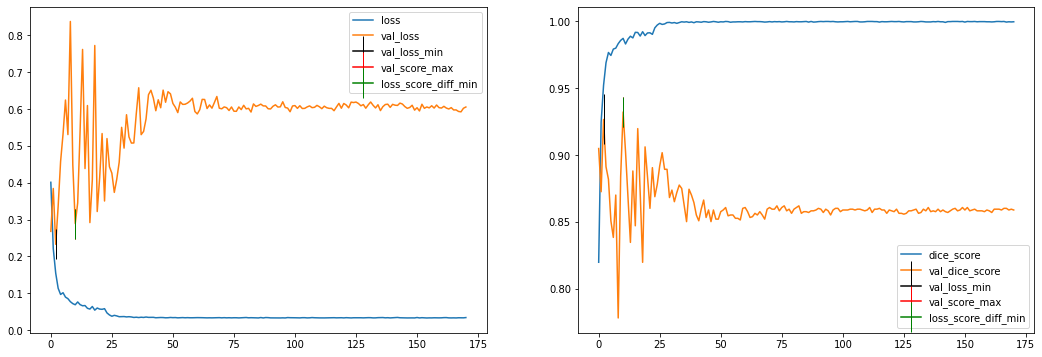

In [9]:
import csv
import shutil
import numpy as np
from glob import glob
from matplotlib import pyplot as plt

result_path = f"./result_daily/{task}/{data_set_name}/{today_str}/gpu_{gpu_number}/target_size_{target_size}/"
result_weights = glob(f'{result_path}/weights/*')

score_name = "accuracy"
val_score_name = "val_accuracy"

with open(f'{result_path}/log.csv') as csv_file:
    reader = csv.DictReader(csv_file)
    dict_from_csv = {field_name:[] for field_name in reader.fieldnames}
    print(reader.fieldnames)
    for row in reader:
        for filedname in reader.fieldnames:
            dict_from_csv[filedname].append(float(row[filedname])) 

loss_min_epoch = np.argmin(dict_from_csv['val_loss']) + 1
loss_min_loss = np.min(dict_from_csv['val_loss'])
loss_min_accuracy = dict_from_csv[val_score_name][loss_min_epoch - 1]

score_max_epoch = np.argmax(dict_from_csv[val_score_name]) + 1
score_max_loss = dict_from_csv['val_loss'][score_max_epoch - 1]
score_max_accuracy = np.max(dict_from_csv[val_score_name])

val_score = dict_from_csv[val_score_name]
score_diff = np.maximum(np.array(dict_from_csv[val_score_name]) - np.array(dict_from_csv[score_name]), 0)

loss_score_diff_min_epoch = np.argmax(val_score - score_diff) + 1
loss_score_diff_min_loss = dict_from_csv['val_loss'][loss_score_diff_min_epoch - 1]
loss_score_diff_min_accuracy = dict_from_csv[val_score_name][loss_score_diff_min_epoch - 1]

print(f"val_loss_min (epoch, loss, accuracy): ({loss_min_epoch}, {loss_min_loss:.4f}, {loss_min_accuracy:.4f})")
print(f"val_dice_score_max (epoch, loss, accuracy): ({score_max_epoch}, {score_max_loss:.4f}, {score_max_accuracy:.4f})")
print(f"loss_score_diff_min (epoch, loss, accuracy): ({loss_score_diff_min_epoch}, {loss_score_diff_min_loss:.4f}, {loss_score_diff_min_accuracy:.4f})")

_, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(dict_from_csv["loss"])
ax[0].plot(dict_from_csv["val_loss"])
ax[0].plot(loss_min_epoch - 1, loss_min_loss, marker="|", color="black", markersize=30)
ax[0].plot(score_max_epoch - 1, dict_from_csv['val_loss'][score_max_epoch - 1], marker="|", color="red", markersize=30)
ax[0].plot(loss_score_diff_min_epoch - 1, dict_from_csv['val_loss'][loss_score_diff_min_epoch - 1], marker="|", color="green", markersize=30)
ax[0].legend(["loss", "val_loss", "val_loss_min", "val_score_max", "loss_score_diff_min"])

ax[1].plot(dict_from_csv[score_name])
ax[1].plot(dict_from_csv[val_score_name])
ax[1].plot(loss_min_epoch - 1, dict_from_csv[val_score_name][loss_min_epoch - 1], marker="|", color="black", markersize=50)
ax[1].plot(score_max_epoch - 1, score_max_accuracy, marker="|", color="red", markersize=30)
ax[1].plot(loss_score_diff_min_epoch - 1, dict_from_csv[val_score_name][loss_score_diff_min_epoch - 1], marker="|", color="green", markersize=30)
ax[1].legend(["dice_score", "val_dice_score", "val_loss_min", "val_score_max", "loss_score_diff_min"])

plt.savefig(f"{result_path}/learning curve.png", dpi=300)
plt.show()
plt.close()


In [10]:
best_loss_path = glob(f"{result_path}/weights/weights_{loss_min_loss:.4f}_*.hdf5")[0]
shutil.copy(best_loss_path, f"{result_path}/epoch_{loss_min_epoch}_loss_{loss_min_loss:.4f}_dice_{loss_min_accuracy:.4f}.hdf5")
print(best_loss_path)

model.load_weights(best_loss_path)
model.evaluate(test_data_loader)

./result_daily/classification/detect_lvi/2021-08-05/gpu_2/target_size_(1024, 1024)//weights/weights_0.2326_0.1544_03.hdf5
1469/1469 [==============================] - 134s 88ms/step - loss: 0.0746 - accuracy: 0.9850


[0.07462472468614578, 0.9850237965583801]

In [11]:
best_score_path = glob(f"{result_path}/weights/*_{score_max_epoch:02d}.hdf5")[0]
shutil.copy(best_score_path, f"{result_path}/epoch_{score_max_epoch}_loss_{score_max_loss:.4f}_dice_{score_max_accuracy:.4f}.hdf5")
print(best_score_path)

model.load_weights(best_score_path)
model.evaluate(test_data_loader)

./result_daily/classification/detect_lvi/2021-08-05/gpu_2/target_size_(1024, 1024)//weights/weights_0.2890_0.0686_11.hdf5
1469/1469 [==============================] - 93s 63ms/step - loss: 0.0876 - accuracy: 0.9803


[0.08761883527040482, 0.9802587032318115]

In [12]:
best_diff_path = glob(f"{result_path}/weights/*_{loss_score_diff_min_epoch:02d}.hdf5")[0]
shutil.copy(best_diff_path, f"{result_path}/epoch_{loss_score_diff_min_epoch}_loss_{loss_score_diff_min_loss:.4f}_dice_{loss_score_diff_min_accuracy:.4f}.hdf5")
print(best_diff_path)

model.load_weights(best_diff_path)
model.evaluate(test_data_loader)

./result_daily/classification/detect_lvi/2021-08-05/gpu_2/target_size_(1024, 1024)//weights/weights_0.2890_0.0686_11.hdf5
1469/1469 [==============================] - 89s 61ms/step - loss: 0.0876 - accuracy: 0.9803


[0.08761883527040482, 0.9802587032318115]

In [13]:
best_diff_path = glob(f"{result_path}/weights/*_100.hdf5")[0]
shutil.copy(best_diff_path, f"{result_path}/epoch_{loss_score_diff_min_epoch}_loss_{loss_score_diff_min_loss:.4f}_dice_{loss_score_diff_min_accuracy:.4f}.hdf5")
print(best_diff_path)

model.load_weights(best_diff_path)
model.evaluate(test_data_loader)

./result_daily/classification/detect_lvi/2021-08-05/gpu_2/target_size_(1024, 1024)//weights/weights_0.6081_0.0335_100.hdf5
1469/1469 [==============================] - 91s 62ms/step - loss: 0.0833 - accuracy: 0.9809


[0.08326104283332825, 0.9809393882751465]

# Inference

In [14]:
best_diff_path = glob(f"{result_path}/weights/*_{loss_score_diff_min_epoch:02d}.hdf5")[0]
model.load_weights(best_diff_path)

current_data_loader = test_data_loader

ground_truth = current_data_loader.data_getter.class_dict
ground_truth = np.array(list(ground_truth.values()))
model_predicted = model.predict(current_data_loader)
model.evaluate(current_data_loader)

1469/1469 [==============================] - 92s 62ms/step - loss: 0.0876 - accuracy: 0.9803


[0.08761883527040482, 0.9802587032318115]

In [16]:
threshold = 0.5

negative_group_1 = np.where(model_predicted < threshold)[0]
negative_group_2 = np.where(model_predicted != 0)[0]
negative_confirm = np.where(model_predicted == 0)[0]
negative_not_confirm = np.intersect1d(negative_group_1, negative_group_2)

positive_group_1 = np.where(model_predicted > threshold)[0]
positive_group_2 = np.where(model_predicted != 1)[0]
postive_confirm = np.where(model_predicted == 1)[0]
postive_not_confirm = np.intersect1d(positive_group_1, positive_group_2)

ground_truth_negative = np.where(ground_truth == 0)[0]
ground_truth_positive = np.where(ground_truth == 1)[0]

true_negative = np.intersect1d(negative_group_1, ground_truth_negative)
true_positive = np.intersect1d(positive_group_1, ground_truth_positive)
false_negative = np.intersect1d(negative_group_1, ground_truth_positive)
false_positive = np.intersect1d(positive_group_1, ground_truth_negative)

print(len(negative_confirm))
print(len(negative_not_confirm))
print(len(postive_confirm))
print(len(postive_not_confirm))

print(false_negative)
print(false_positive)

0
760
0
709
[1049 1054 1068 1075 1076 1082 1084 1085 1086 1465]
[ 18  32  51  56  69 174 197 292 446 471 497 524 528 530 531 539 542 597
 762]


In [ ]:
#Confusion Matrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import datetime
import numpy as np
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
testset = 'G:/EBV_Pathology/data_ebv/test'
test_labels = ['ebv_neg','ebv_pos']

ground_truth_label = ground_truth > threshold
model_predicted_label = model_predicted > threshold
print("Accurance : {}".format(accuracy_score(ground_truth_label, model_predicted_label)))

CM  = confusion_matrix(ground_truth_label, model_predicted_label)
ax = plt.axes()
sn.heatmap(CM,annot=True, xticklabels=test_labels, yticklabels=test_labels, ax = ax, cmap="Blues",fmt='g')
ax.set_title('Confision Matrix')
plt.show()

